# MOFA vs PCA

This notebook compares PCA and MOFA as latent representations for the TCGA-BRCA multi-omics data. We load pre-computed factors/components, quantify how much variance they explain in each omic view (R² curves and factor-by-view heatmaps), and relate the MOFA factors to PAM50 subtypes. The goal is to understand how PCA and MOFA differ in terms of variance captured, multi-view structure, and label relevance, and to compare them as classifiers.


In [2]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from utils.omic_helpers import *
import scanpy as sc
import muon as mu
import mofax as mofa

sns.set(style="whitegrid")


### Load data

In [3]:
data_dir = "./../data/TCGA-BRCA/"
mods = ["mRNA", "DNAm", "RPPA"]

data = {}
for omic in mods:
    with open(f"{data_dir}{omic}.pkl", "rb") as f:
        data[omic] = pickle.load(f)

list(data.keys())


C:\Users\Petar\AppData\Local\Temp\ipykernel_4404\2711072643.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data[omic] = pickle.load(f)
C:\Users\Petar\AppData\Local\Temp\ipykernel_4404\2711072643.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access f

['mRNA', 'DNAm', 'RPPA']

### Sample intersection

In [4]:
idx_rna  = set(data["mRNA"]["expr"].index)
idx_meth = set(data["DNAm"]["expr"].index)
idx_prot = set(data["RPPA"]["expr"].index)

patients_intersection_all = sorted(idx_rna & idx_meth & idx_prot)

print(f"mRNA samples: {len(idx_rna)}")
print(f"DNAm samples: {len(idx_meth)}")
print(f"RPPA samples: {len(idx_prot)}")
print(f"Intersection (all three): {len(patients_intersection_all)}")


mRNA samples: 500
DNAm samples: 500
RPPA samples: 500
Intersection (all three): 401


### PAM50 labels and combined PAM50_any

In [5]:
pam_rna  = get_pam50(data, "mRNA")
pam_meth = get_pam50(data, "DNAm")
pam_prot = get_pam50(data, "RPPA")

pam_any = pam_rna.copy()
pam_any = pam_any.combine_first(pam_meth)
pam_any = pam_any.combine_first(pam_prot)
pam_any.name = "PAM50_any"

pam_any.value_counts(dropna=False)


PAM50_any
LumA     352
LumB     138
Basal    119
Her2      49
Name: count, dtype: int64

### Load MOFA - change for different model

In [13]:
import mofax as mofa

# Load trained MOFA model
# change this import if you want different model to be loaded
model = mofa.mofa_model("../models/mofa/exports_500/mofa_anova_Kperview_intersection.hdf5")
# Get factors as a DataFrame (rows = samples, cols = Factor1..K)
# If you know you have exactly 15 factors:
mofa_scores = model.get_factors(factors=range(15), df=True)

# Just in case column names are not already Factor1..FactorK
mofa_scores.columns = [f"Factor{i+1}" for i in range(mofa_scores.shape[1])]

# Use PAM50_any labels we built before
pam_mofa = pam_any.copy()
pam_mofa.name = "PAM50_any"

# Keep only samples that have both MOFA factors and PAM50 labels - just to check
common = mofa_scores.index.intersection(pam_mofa.index)
mofa_scores = mofa_scores.loc[common]
pam_mofa    = pam_mofa.loc[common]
pam_mofa.name = "PAM50_any"

mofa_scores.shape, pam_mofa.shape 

((401, 15), (401,))

### Choose K per view and select top-variance/ANOVA features for PCA

In [14]:
K_PER_VIEW = {"mRNA": 500, "DNAm": 500, "RPPA": 464}

filtered_data_var, feat_idx_var = select_top_variable_features_per_view(
    data=data,
    n_keep_per_view=K_PER_VIEW,
    views=["mRNA", "DNAm", "RPPA"],
    use="var",
)

mRNA: kept 500 / 29995 features (most variable, var)
DNAm: kept 500 / 100000 features (most variable, var)
RPPA: kept 464 / 464 features (most variable, var)


In [13]:
K_PER_VIEW = {"mRNA": 500, "DNAm": 500, "RPPA": 464}

filtered_data_anova, feat_idx_anova = select_top_anova_features_per_view(
    data=data,
    n_keep_per_view=K_PER_VIEW,
    views=["mRNA", "DNAm", "RPPA"]
)


mRNA: kept 500 / 29995 features (ANOVA)
DNAm: kept 500 / 100000 features (ANOVA)
RPPA: kept 464 / 464 features (ANOVA)


### Patient set used for comparison - reducing to intersection patients 

If you want to run logreg on all patients for MOFA, skip until the classification part!

In [14]:
patients_pca = mofa_scores.index

for v in ["mRNA", "DNAm", "RPPA"]:
    patients_pca = patients_pca.intersection(filtered_data_var[v]["expr"].index)

patients_pca = patients_pca.sort_values()
len(patients_pca)


401

In [15]:
N_FACTORS = 15

mofa_scores_15 = mofa_scores.loc[patients_pca].iloc[:, :N_FACTORS]
pam_pca        = pam_mofa.loc[patients_pca]
pam_pca.name   = "PAM50_any"

mofa_scores_15.shape, pam_pca.shape


((401, 15), (401,))

### PCA per view (top-K most variable features)

In [16]:
N_PCS = 15

pca_rna,  scores_rna,  load_rna  = run_pca_view(
    filtered_data_var, "mRNA", patients=patients_pca, n_components=N_PCS
)
pca_meth, scores_meth, load_meth = run_pca_view(
    filtered_data_var, "DNAm", patients=patients_pca, n_components=N_PCS
)
pca_prot, scores_prot, load_prot = run_pca_view(
    filtered_data_var, "RPPA", patients=patients_pca, n_components=N_PCS
)

scores_rna_15  = scores_rna.iloc[:, :N_PCS]
scores_meth_15 = scores_meth.iloc[:, :N_PCS]
scores_prot_15 = scores_prot.iloc[:, :N_PCS]

scores_rna_15.shape, scores_meth_15.shape, scores_prot_15.shape


((401, 15), (401, 15), (401, 15))

### Combined PCA on concatenated top-K features

In [17]:
X_concat = get_concat_matrix(filtered_data_var, patients=patients_pca, block_scale=True)  # var (will do all on this as it is biologically more plausible)
X_concat_anova = get_concat_matrix(filtered_data_anova, patients=patients_pca, block_scale=True) # anova (only for clasification)

pca_combined = PCA(n_components=N_PCS, random_state=0)
scores_combined = pd.DataFrame(
    pca_combined.fit_transform(X_concat.values),
    index=X_concat.index,
    columns=[f"PC{i+1}" for i in range(N_PCS)],
)
scores_combined_15 = scores_combined.iloc[:, :N_PCS]

scores_combined_15.shape


(401, 15)

### Plots - factors in 2D and 3D space

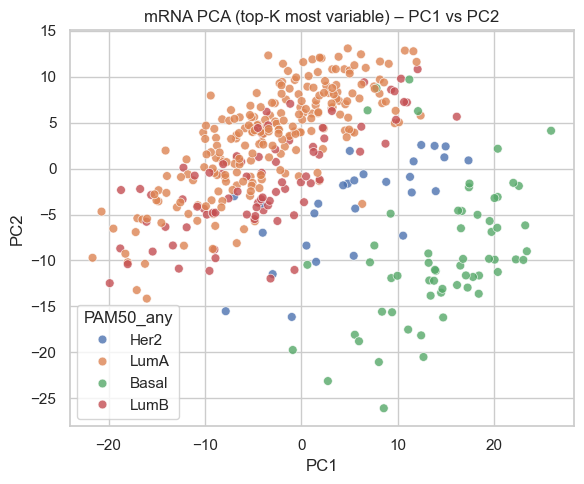

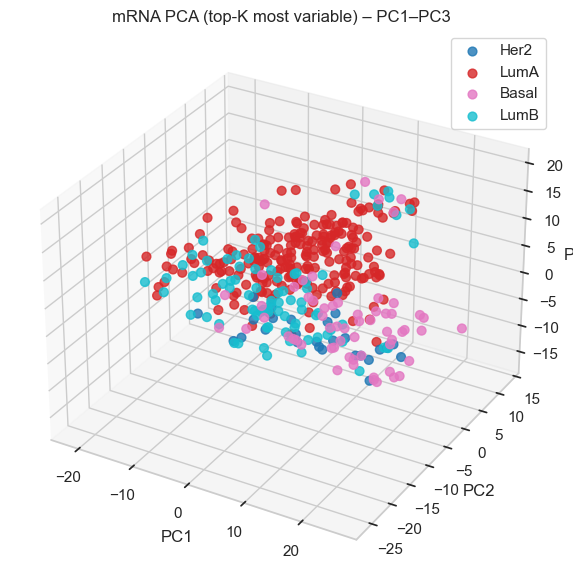

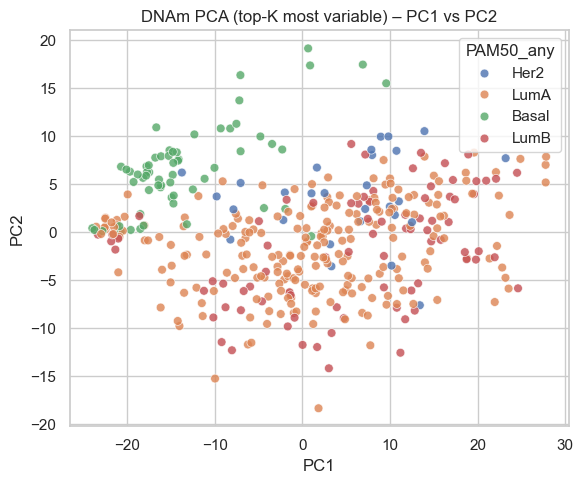

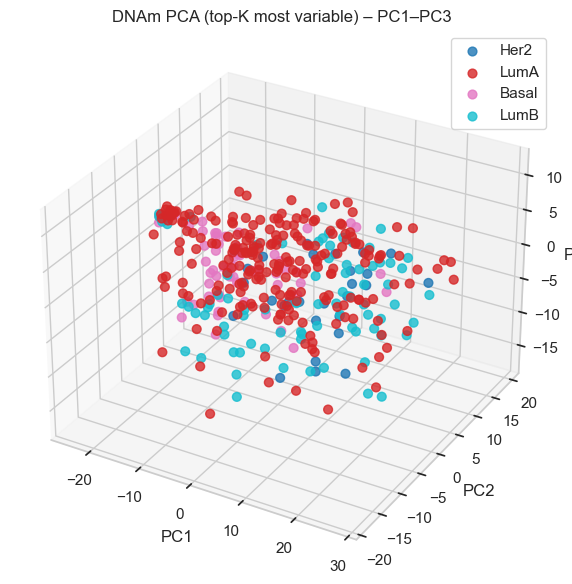

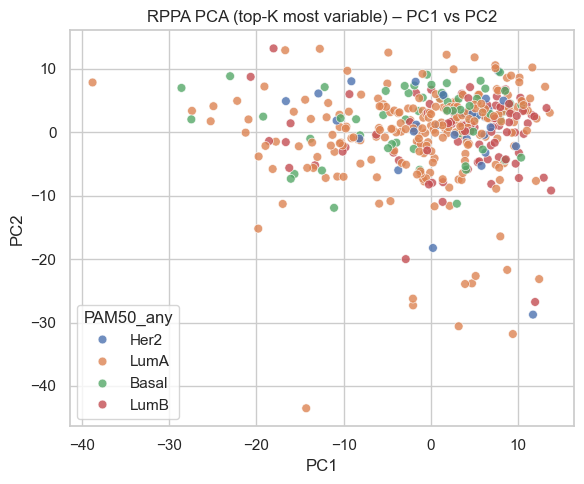

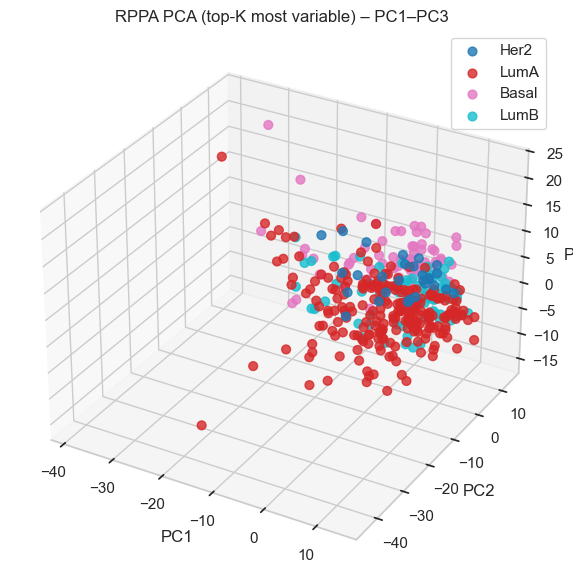

In [18]:
# === PCA per view: 2D and 3D (PC1–PC3) with PAM50_any labels ===

view_pca_scores = {
    "mRNA": scores_rna_15,
    "DNAm": scores_meth_15,
    "RPPA": scores_prot_15,
}

for view_name, scores_df in view_pca_scores.items():
    # 2D plot PC1 vs PC2
    plot_pca_2d(
        scores_df,
        labels=pam_pca,
        x_pc=1,
        y_pc=2,
        title=f"{view_name} PCA (top-K most variable) – PC1 vs PC2",
    )

    # 3D plot PC1, PC2, PC3
    plot_pca_3d(
        scores_df,
        labels=pam_pca,
        pcs=(1, 2, 3),
        title=f"{view_name} PCA (top-K most variable) – PC1–PC3",
    )


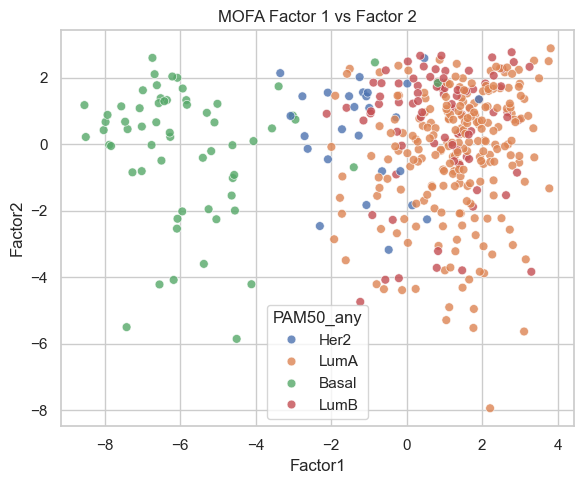

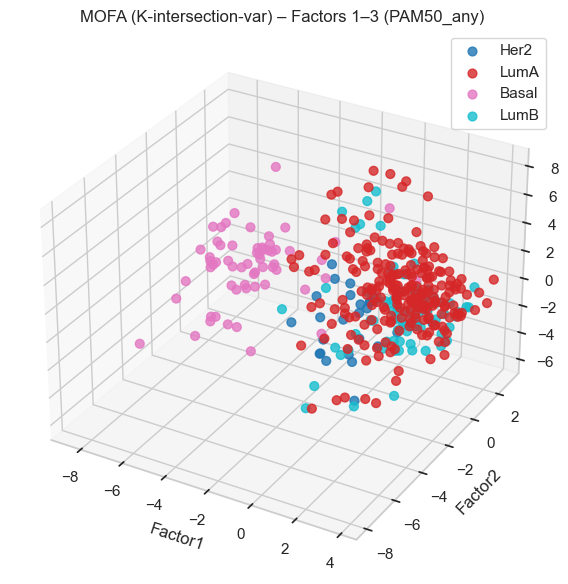

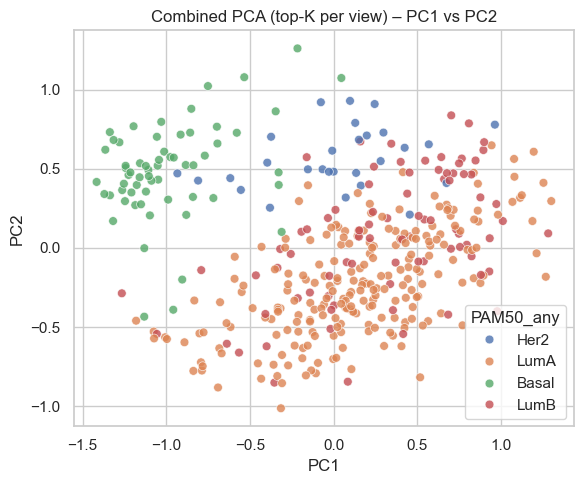

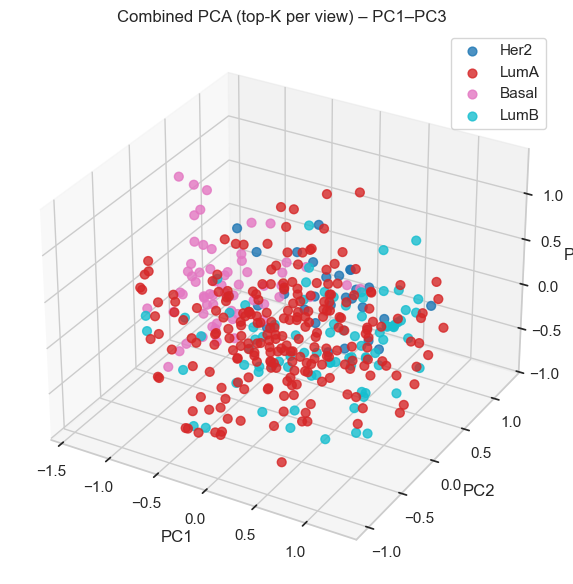

In [19]:
# MOFA – 2D and 3D
plot_mofa_2d(
    mofa_scores_15,
    labels=pam_pca,
    x_f=1,
    y_f=2,
    title="MOFA Factor 1 vs Factor 2",
    savepath="mofa_2d_pam50.pdf",   # <- for LaTeX
)


plot_mofa_3d(
    mofa_scores_15,
    labels=pam_pca,
    factors=(1, 2, 3),
    title="MOFA (K-intersection-var) – Factors 1–3 (PAM50_any)"
)

# Combined PCA – 2D and 3D
plot_pca_2d(
    scores_combined_15,
    labels=pam_pca,
    x_pc=1,
    y_pc=2,
    title="Combined PCA (top-K per view) – PC1 vs PC2"
)

plot_pca_3d(
    scores_combined_15,
    labels=pam_pca,
    pcs=(1, 2, 3),
    title="Combined PCA (top-K per view) – PC1–PC3"
)


### R² per factor and per view (MOFA vs combined PCA)

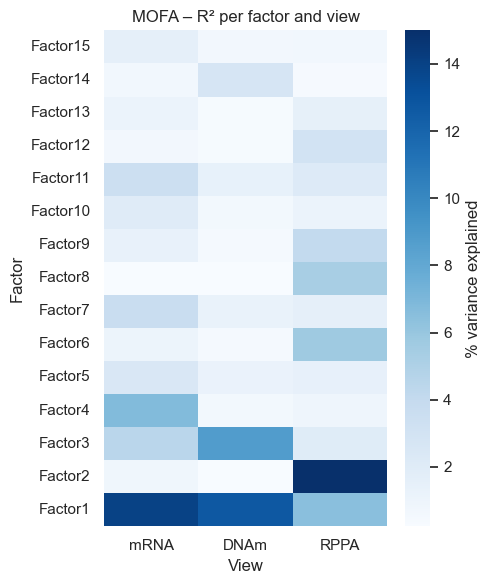

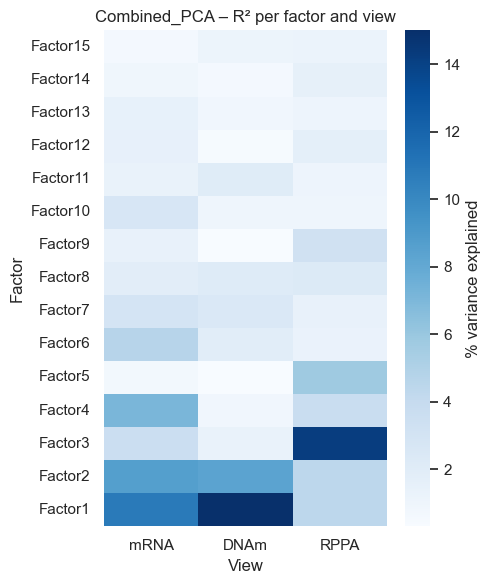

In [20]:
views_var = {
    "mRNA": filtered_data_var["mRNA"]["expr"].loc[patients_pca],
    "DNAm": filtered_data_var["DNAm"]["expr"].loc[patients_pca],
    "RPPA": filtered_data_var["RPPA"]["expr"].loc[patients_pca],
}

embeddings_r2 = {
    "MOFA":         mofa_scores_15,
    "Combined_PCA": scores_combined_15,
}

for emb_name, Z in embeddings_r2.items():
    r2_mat = per_factor_r2_matrix(views_var, Z, n_factors=N_FACTORS)
    r2_percent = 100 * r2_mat
    r2_percent_inv = r2_percent.iloc[::-1]  # Factor1 at bottom

    plt.figure(figsize=(5, 6))
    sns.heatmap(
        r2_percent_inv,
        cmap="Blues",
        vmax=15,
        cbar_kws={"label": "% variance explained"},
    )
    plt.title(f"{emb_name} – R² per factor and view")
    plt.xlabel("View")
    plt.ylabel("Factor")
    plt.tight_layout()
    plt.show()


#### For report

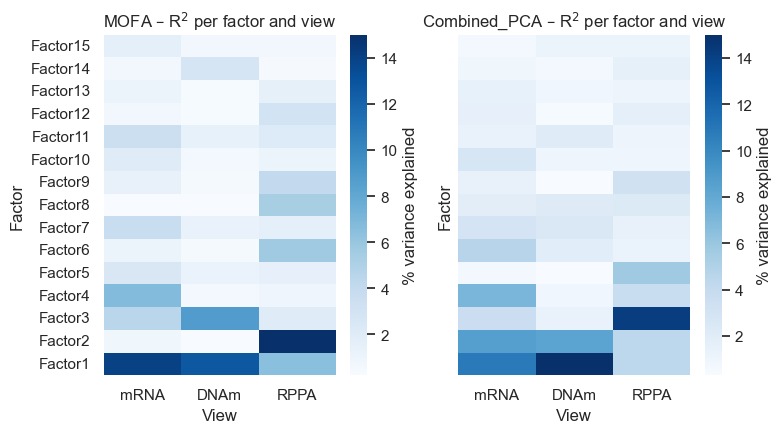

In [21]:
views_var = {
    "mRNA": filtered_data_var["mRNA"]["expr"].loc[patients_pca],
    "DNAm": filtered_data_var["DNAm"]["expr"].loc[patients_pca],
    "RPPA": filtered_data_var["RPPA"]["expr"].loc[patients_pca],
}

embeddings_r2 = [
    ("MOFA",         mofa_scores_15),
    ("Combined_PCA", scores_combined_15),
]

fig, axes = plt.subplots(1, 2, figsize=(8, 4.5), sharey=True)

for ax, (emb_name, Z) in zip(axes, embeddings_r2):
    r2_mat = per_factor_r2_matrix(views_var, Z, n_factors=N_FACTORS)
    r2_percent = 100 * r2_mat
    r2_percent_inv = r2_percent.iloc[::-1]  # Factor1 at bottom

    sns.heatmap(
        r2_percent_inv,
        ax=ax,
        cmap="Blues",
        vmax=15,
        cbar_kws={"label": "% variance explained"},
    )
    ax.set_title(f"{emb_name} – R$^2$ per factor and view")
    ax.set_xlabel("View")
    ax.set_ylabel("Factor")

fig.tight_layout()
fig.savefig("fig_var_expl_heatmaps.pdf", dpi=300, bbox_inches="tight")
plt.show()


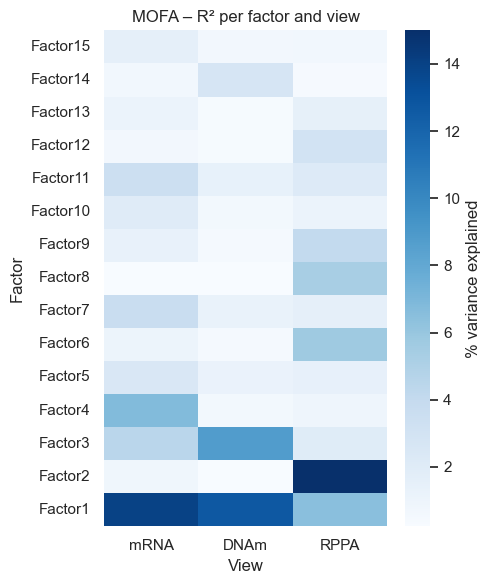

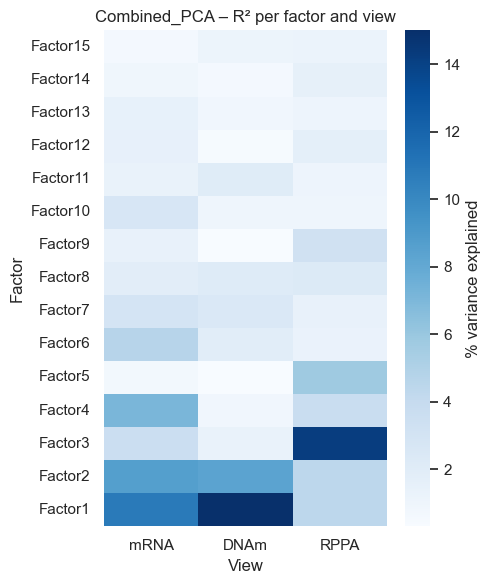

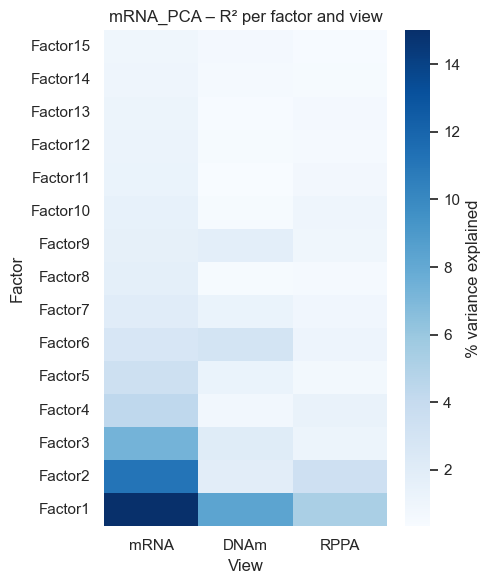

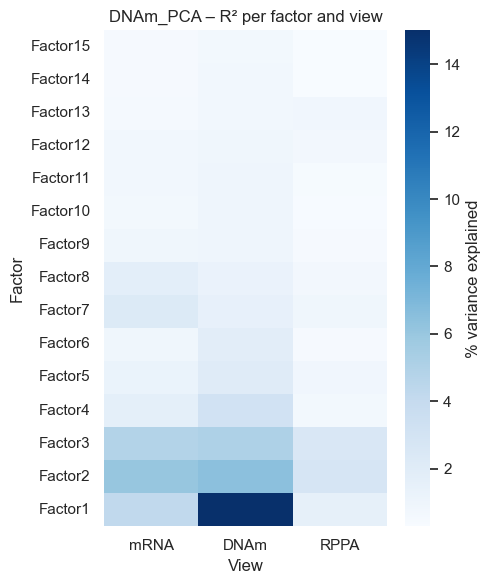

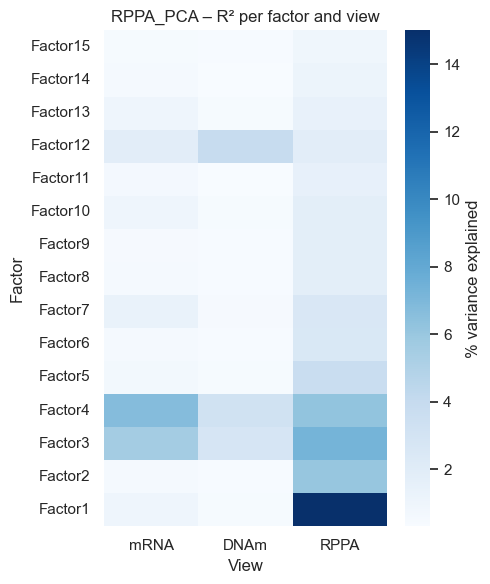

In [22]:
# === R² per factor and per view (MOFA + all PCAs) ===

views_var = {
    "mRNA": filtered_data_var["mRNA"]["expr"].loc[patients_pca],
    "DNAm": filtered_data_var["DNAm"]["expr"].loc[patients_pca],
    "RPPA": filtered_data_var["RPPA"]["expr"].loc[patients_pca],
}

embeddings_r2 = {
    "MOFA":         mofa_scores_15,
    "Combined_PCA": scores_combined_15,
    "mRNA_PCA":     scores_rna_15,
    "DNAm_PCA":     scores_meth_15,
    "RPPA_PCA":     scores_prot_15,
}

for emb_name, Z in embeddings_r2.items():
    r2_mat = per_factor_r2_matrix(views_var, Z, n_factors=N_FACTORS)
    r2_percent = 100 * r2_mat
    r2_percent_inv = r2_percent.iloc[::-1]  # Factor1 at bottom

    plt.figure(figsize=(5, 6))
    sns.heatmap(
        r2_percent_inv,
        cmap="Blues",
        vmax=15,
        cbar_kws={"label": "% variance explained"},
    )
    plt.title(f"{emb_name} – R² per factor and view")
    plt.xlabel("View")
    plt.ylabel("Factor")
    plt.tight_layout()
    plt.show()


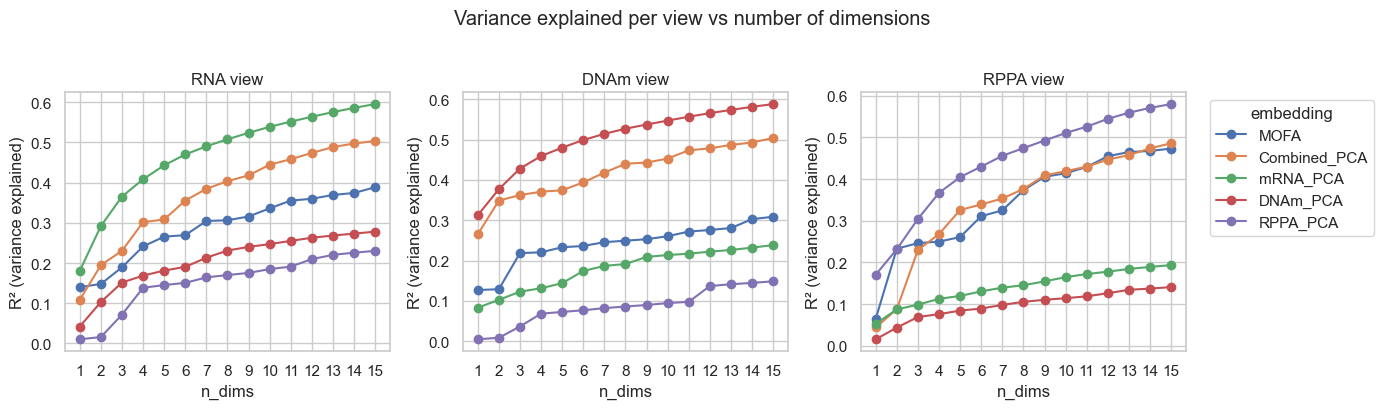

In [23]:
# === R² vs number of dimensions, per view & embedding ===

embeddings_all = {
    "MOFA":         mofa_scores_15,
    "Combined_PCA": scores_combined_15,
    "mRNA_PCA":     scores_rna_15,
    "DNAm_PCA":     scores_meth_15,
    "RPPA_PCA":     scores_prot_15,
}

dims = range(1, N_PCS + 1)

r2_curves = {
    vname: pd.DataFrame(index=dims, columns=embeddings_all.keys(), dtype=float)
    for vname in views_var.keys()
}

for vname, X_df in views_var.items():
    for d in dims:
        for emb_name, Z_df in embeddings_all.items():
            r2 = variance_explained_view(X_df, Z_df.iloc[:, :d])
            r2_curves[vname].loc[d, emb_name] = r2


fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

view_order = ["mRNA", "DNAm", "RPPA"]
view_titles = {
    "mRNA": "RNA view",
    "DNAm": "DNAm view",
    "RPPA": "RPPA view",
}

for ax, vname in zip(axes, view_order):
    df = r2_curves[vname]
    for emb_name in df.columns:
        ax.plot(df.index, df[emb_name], marker="o", label=emb_name)
    ax.set_title(view_titles[vname])
    ax.set_xlabel("n_dims")
    ax.set_ylabel("R² (variance explained)")
    ax.set_xticks(list(dims))

# put legend only once (on the last axis or outside)
axes[-1].legend(title="embedding", bbox_to_anchor=(1.05, 1), loc="upper left")

fig.suptitle("Variance explained per view vs number of dimensions", y=1.02)
plt.tight_layout()
plt.show()


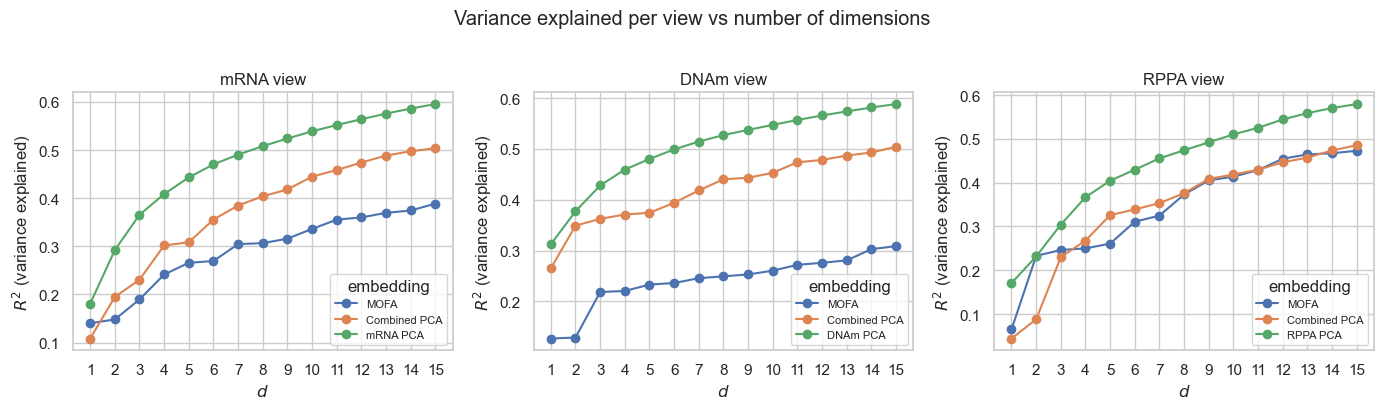

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

view_order = ["mRNA", "DNAm", "RPPA"]
view_titles = {
    "mRNA": "mRNA view",
    "DNAm": "DNAm view",
    "RPPA": "RPPA view",
}

# which curves (columns) to show for each view
view_to_cols = {
    "mRNA": ["MOFA", "Combined_PCA", "mRNA_PCA"],
    "DNAm": ["MOFA", "Combined_PCA", "DNAm_PCA"],
    "RPPA": ["MOFA", "Combined_PCA", "RPPA_PCA"],
}

for ax, vname in zip(axes, view_order):
    df   = r2_curves[vname]       # df.index = n_dims
    cols = view_to_cols[vname]

    # labels we want in the legend for THIS view
    nice_labels = ["MOFA", "Combined PCA", f"{vname} PCA"]

    for col, lab in zip(cols, nice_labels):
        ax.plot(df.index, df[col], marker="o", label=lab)

    ax.set_title(view_titles[vname])
    ax.set_xlabel("$d$")
    ax.set_ylabel(r"$R^2$ (variance explained)")
    ax.set_xticks(list(df.index))
    ax.legend(title="embedding", fontsize=8, loc="lower right")

fig.tight_layout()
fig.suptitle("Variance explained per view vs number of dimensions", y=1.02)
fig.tight_layout()

# Save for LaTeX
fig.savefig("fig_var_expl_curves.pdf", dpi=300, bbox_inches="tight")  # or .png

plt.show()

plt.show()


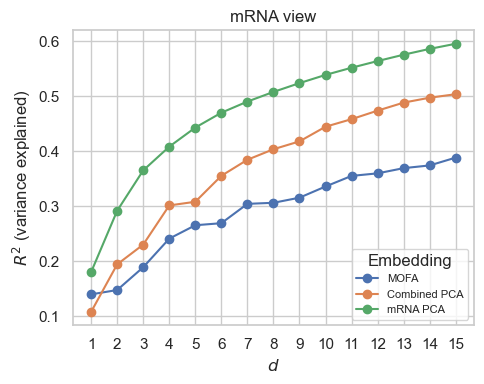

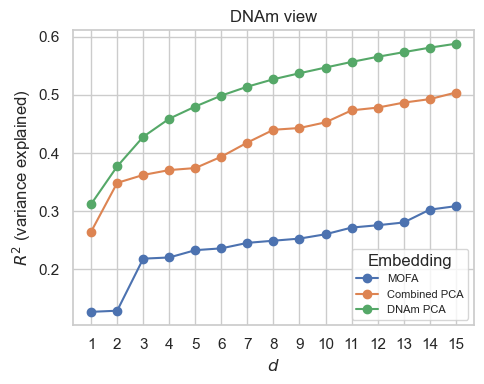

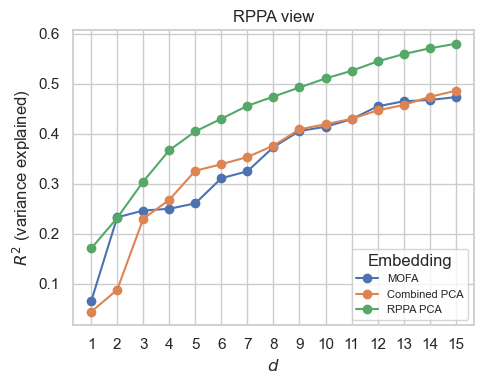

In [25]:
view_order = ["mRNA", "DNAm", "RPPA"]
view_titles = {
    "mRNA": "mRNA view",
    "DNAm": "DNAm view",
    "RPPA": "RPPA view",
}

view_to_cols = {
    "mRNA": ["MOFA", "Combined_PCA", "mRNA_PCA"],
    "DNAm": ["MOFA", "Combined_PCA", "DNAm_PCA"],
    "RPPA": ["MOFA", "Combined_PCA", "RPPA_PCA"],
}

for vname in view_order:
    fig, ax = plt.subplots(figsize=(5, 4))  # adjust size as you like

    df   = r2_curves[vname]       # df.index = n_dims
    cols = view_to_cols[vname]
    nice_labels = ["MOFA", "Combined PCA", f"{vname} PCA"]

    for col, lab in zip(cols, nice_labels):
        ax.plot(df.index, df[col], marker="o", label=lab)

    ax.set_title(view_titles[vname])
    ax.set_xlabel("$d$")
    ax.set_ylabel(r"$R^2$ (variance explained)")
    ax.set_xticks(list(df.index))
    ax.legend(title="Embedding", fontsize=8, loc="lower right")

    fig.tight_layout()

    # Save one file per view
    fig.savefig(f"fig_var_expl_curves_{vname}.pdf", dpi=300, bbox_inches="tight")
    fig.savefig(f"fig_var_expl_curves_{vname}.png", dpi=300, bbox_inches="tight")

    plt.show()


### Silhouette analysis (overall, dims 2–15)

In [19]:
dims = range(2, N_PCS + 1)

embeddings_sil = {
    "MOFA":         mofa_scores_15,
    "Combined_PCA": scores_combined_15,
}

overall_sil = pd.DataFrame(index=embeddings_sil.keys(), columns=dims, dtype=float)

for d in dims:
    for name, Z in embeddings_sil.items():
        overall_sil.loc[name, d] = silhouette_in_embedding(
            Z, pam_pca, n_dims=d
        )

overall_sil


,2,3,4,5,6,7,8,9,10,11,12,13,14,15
MOFA,0.063412,0.133991,0.152665,0.129066,0.113016,0.159335,0.144003,0.140796,0.129795,0.125071,0.122073,0.117415,0.112640,0.110220
Combined_PCA,0.117019,0.087733,0.084225,0.072602,0.079438,0.085574,0.086155,0.081389,0.079948,0.081728,0.080275,0.079403,0.080304,0.079935


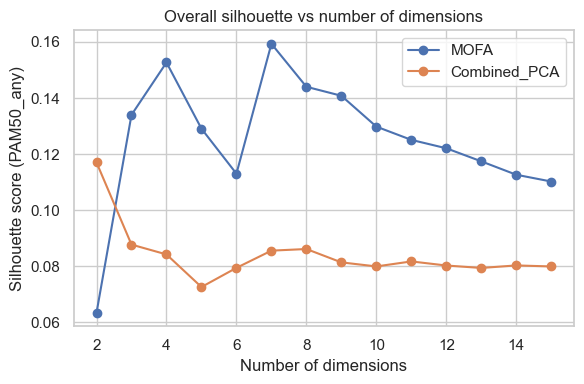

In [20]:
plt.figure(figsize=(6, 4))
for name in embeddings_sil.keys():
    plt.plot(dims, overall_sil.loc[name], marker="o", label=name)

plt.xlabel("Number of dimensions")
plt.ylabel("Silhouette score (PAM50_any)")
plt.title("Overall silhouette vs number of dimensions")
plt.legend()
plt.tight_layout()
plt.show()


### Factor ↔ subtype correlation matrix (MOFA)

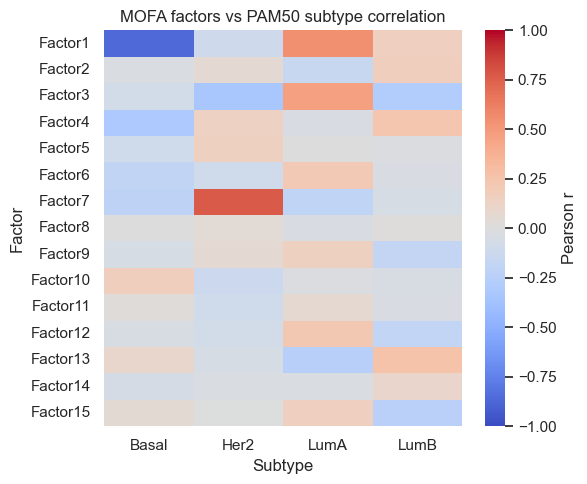

In [21]:
corr_mofa = factor_class_correlation_matrix(
    mofa_scores_15,
    pam_pca,
    n_factors=N_FACTORS,
)
corr_mofa

fig = plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_mofa,
    cmap="coolwarm",
    center=0.0,
    vmin=-1.0,
    vmax=1.0,
    cbar_kws={"label": "Pearson r"},
)
plt.title("MOFA factors vs PAM50 subtype correlation")
plt.xlabel("Subtype")
plt.ylabel("Factor")
plt.tight_layout()

fig.savefig("corr_matrix.pdf", dpi=300, bbox_inches="tight")  # or .png

plt.show()


#### Inspection of some factors in 2D

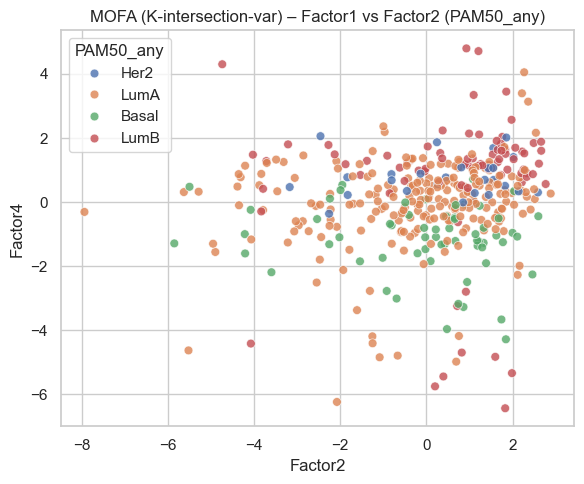

In [22]:
plot_mofa_2d(
    mofa_scores_15,
    labels=pam_pca,
    x_f=2,
    y_f=4,
    title="MOFA (K-intersection-var) – Factor1 vs Factor2 (PAM50_any)"
)

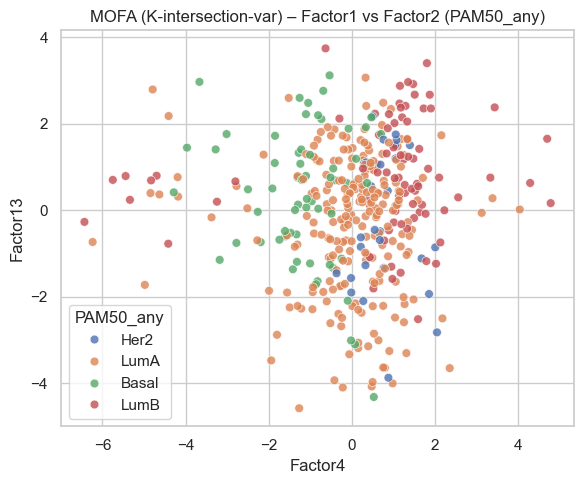

In [23]:
plot_mofa_2d(
    mofa_scores_15,
    labels=pam_pca,
    x_f=4,
    y_f=13,
    title="MOFA (K-intersection-var) – Factor1 vs Factor2 (PAM50_any)"
)

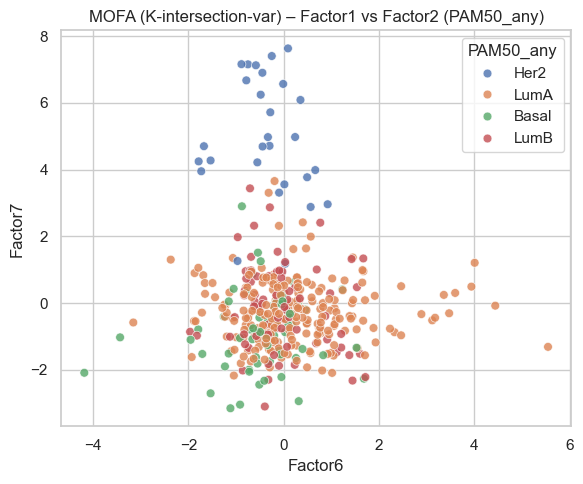

In [24]:
plot_mofa_2d(
    mofa_scores_15,
    labels=pam_pca,
    x_f=6,
    y_f=7,
    title="MOFA (K-intersection-var) – Factor1 vs Factor2 (PAM50_any)"
)

### Logistic regression CV (MOFA vs combined PCA, with std)

C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


MOFA (K-intersection-var): best params {'clf__C': 1.0, 'clf__penalty': 'l1'}
CV balanced accuracy: 0.878 ± 0.064
Test balanced accuracy: 0.803
Test accuracy:        0.802
Test ROC-AUC (OvR):   0.917

Classification report:
              precision    recall  f1-score   support

       Basal       0.92      1.00      0.96        12
        Her2       0.71      0.83      0.77         6
        LumA       0.85      0.85      0.85        46
        LumB       0.60      0.53      0.56        17

    accuracy                           0.80        81
   macro avg       0.77      0.80      0.78        81
weighted avg       0.80      0.80      0.80        81



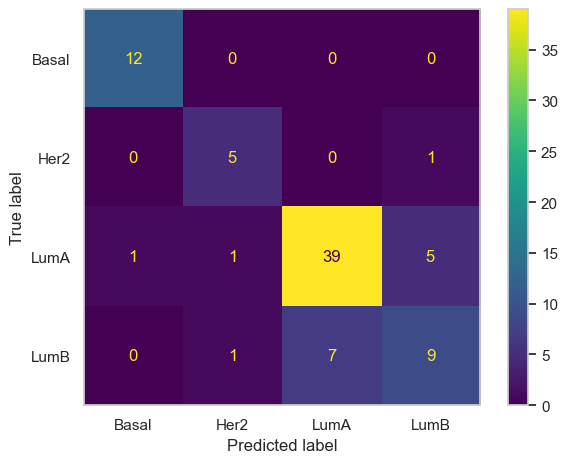

In [25]:
results_mofa = run_logreg_on_factors(
    X_factors=mofa_scores,
    labels_any=pam_mofa,
    title="MOFA (K-intersection-var)",
    verbose=True,
)

C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Combined PCA (15) (PCA 15): best params {'clf__C': 0.1, 'clf__penalty': 'l1'}
CV balanced accuracy: 0.886 ± 0.067
Test balanced accuracy: 0.803
Test accuracy:        0.802
Test ROC-AUC (OvR):   0.925

Classification report:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00        12
        Her2       0.83      0.83      0.83         6
        LumA       0.85      0.85      0.85        46
        LumB       0.53      0.53      0.53        17

    accuracy                           0.80        81
   macro avg       0.80      0.80      0.80        81
weighted avg       0.80      0.80      0.80        81



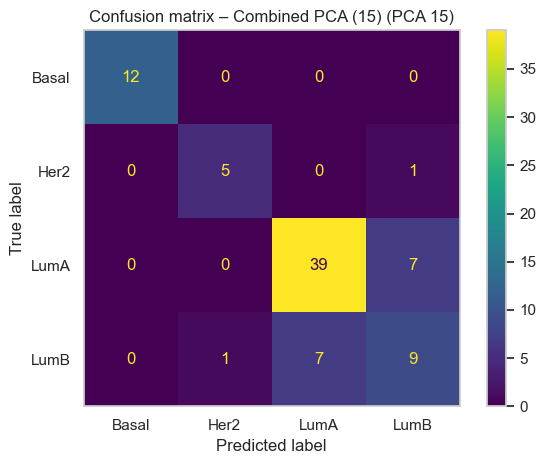

,best_params,mean_cv_bal_acc,std_cv_bal_acc,test_bal_acc,test_acc,test_roc_auc_ovr
title,,,,,,
MOFA (K-intersection-var),"{'clf__C': 1.0, 'clf__penalty': 'l1'}",0.878166,0.064123,0.802643,0.802469,0.917288
Combined PCA (15) (PCA 15),"{'clf__C': 0.1, 'clf__penalty': 'l1'}",0.885906,0.066986,0.802643,0.802469,0.924791


In [26]:
results_pca = run_logreg_with_pca(
    X_concat_anova,
    pam_pca,   # or whatever your labels_any is called
    title="Combined PCA (15)",
    n_components=15,
    verbose=True,
)

pd.DataFrame([results_mofa, results_pca]).set_index("title")